In [ ]:
# default_exp macrotools

# Tools to create macros for GATE simulations

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
from ProtonBeamTherapy.analysis import *

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

## MacroWriter class
Main class for creating a macro file to be run by [Gate](http://www.opengatecollaboration.org). 

In [ ]:
#export
import subprocess
from os import path
from time import strftime

class MacroWriter:
    """Main class for creating a macro file to be run by `gate`
    
    """
    def __init__(self, macro_folder='../mac', results_folder='../results', logs_folder='../logs', system_thickness=1,
                 system_y_loc=0, sensor_material='Silicon', physics_list='QGSP_BERT_EMV'):
        self.macro = macro_folder
        self.results = results_folder
        self.logs = logs_folder
        self.sensor_material = sensor_material
        self.physics_list = physics_list
        self.macro_dict = dict.fromkeys(['geometry', 'physics', 'actors', 'intialisation', 'beam', 'start_beam'])
        self.geometry_dict = {}
        self.physics_dict = {}
        self.actor_dict = {}
        self.no_system = True
        self.system_y_loc = system_y_loc
        self.system_thickness = system_thickness
        self.results_files = {key:[] for key in ['trackers', 'hits', 'dose']}
        self.timestamp = strftime("%Y%b%d_%H%M%S")
        self.beam_created = False
        
    def create_sensor(self, n=0, x_length=20, z_length=20, thickness=0.1, x_loc=0, y_loc=0, z_loc=0, 
                  system='scanner'):
    
        """Compose a GATE macro for creating a sensor

        In the current implementation snesor is a flat plane perpendicular to the beam 
        which is by default in y direction
        thickness dimension is in mm
        all other dimensions are in cm"""
        
        # move starting point from the center to the top_surface of the system
        # print(f'system thickness: {self.system_thickness}')
        y_loc = self.system_thickness / 2 - thickness / 2 + y_loc       
        # print(f'y location of sensor {n} is: {y_loc}')
        # create system fisrt but only once
        geometry_lines = ''
        if self.no_system:
            # print(f'system created with: thickness: {self.system_thickness} at loc: {self.system_y_loc}')
            geometry_lines += self.create_system(thickness = self.system_thickness, y_loc=self.system_y_loc)
            self.no_system = False
            
        # then add sensor lines
        geometry_lines += f"""
        #sensor
        /gate/scanner/daughters/name sensor{n}
        /gate/{system}/daughters/insert box
        /gate/sensor{n}/geometry/setXLength      {x_length} cm
        /gate/sensor{n}/geometry/setYLength      {round(thickness,3)} mm
        /gate/sensor{n}/geometry/setZLength      {z_length} cm
        /gate/sensor{n}/setMaterial {self.sensor_material}
        /gate/sensor{n}/placement/setTranslation {x_loc} {y_loc} {z_loc} cm
        /gate/sensor{n}/vis/setVisible 1
        /gate/sensor{n}/vis/setColor magenta
        /gate/systems/{system}/level1/attach sensor{n}
        /gate/sensor{n}/attachCrystalSD
        """
        
        physics_lines = f"""
        """

        self.geometry_dict[f'sensor{n}'] = geometry_lines
        self.physics_dict[f'sensor{n}'] = physics_lines
            
    def create_system(self, x_length=20, z_length=20, thickness=1, x_loc=0, y_loc=0, z_loc=0, 
                      system='scanner'):
        system_lines = f'''
        /gate/world/daughters/name              {system}
        /gate/world/daughters/insert            box
        /gate/scanner/geometry/setXLength      {x_length} cm
        /gate/scanner/geometry/setYLength      {thickness} cm
        /gate/scanner/geometry/setZLength      {z_length} cm
        /gate/scanner/placement/setTranslation {x_loc} {y_loc} {z_loc} cm
        /gate/scanner/setMaterial Air
        /gate/scanner/vis/setVisible 1
        /gate/scanner/vis/setColor cyan
        /gate/scanner/vis/setLineStyle dashed
        '''
        return system_lines
        
    def create_phantom_layer(self, n=0, x_length=20, z_length=20, thickness=1, x_loc=0, y_loc=0, z_loc=0, 
                             material='Water', color='blue'):
        '''
        Compose a GATE macro for creating a phantom box.
        
        which in the current implementation is a flat box perpendicular to beam which is in y direction
        all dimensions are in cm
        '''
        tracker_results_path = path.join(self.results, f'tracker_{self.timestamp}_{n}.root')
        dose_results_path = path.join(self.results, f'dose_{self.timestamp}_{n}.txt')
        
        self.results_files['trackers'].append(tracker_results_path)
        self.results_files['dose'].append(dose_results_path)
        if material == 'Skull':
            color = 'yellow'
        
        geometry_lines = f"""
        #phatom box {n}
        /gate/world/daughters/name              box{n}
        /gate/world/daughters/insert            box
        /gate/box{n}/geometry/setXLength      {x_length} cm
        /gate/box{n}/geometry/setYLength      {thickness} cm
        /gate/box{n}/geometry/setZLength      {z_length} cm
        /gate/box{n}/placement/setTranslation {x_loc} {y_loc} {z_loc} cm
        /gate/box{n}/setMaterial {material}
        /gate/box{n}/vis/setVisible 1
        /gate/box{n}/vis/setColor {color}
        """
        physics_lines = f"""#*************************************************************
        #  Physics (infrared divergence) cuts for the layer{n}
        #*************************************************************
        /gate/physics/Gamma/SetCutInRegion      box{n} 0.1 mm
        /gate/physics/Electron/SetCutInRegion   box{n} 0.1 mm
        /gate/physics/Positron/SetCutInRegion   box{n} 0.1 mm
        """
        actor_lines = f"""#*************************************************************
        # attached actor to the box{n}
        #***************************************************************
        /gate/actor/addActor PhaseSpaceActor         tracker{n}
        /gate/actor/tracker{n}/save                     {tracker_results_path}
        /gate/actor/tracker{n}/attachTo                 box{n}
        /gate/actor/tracker{n}/enableNuclearFlag          true
        /gate/actor/tracker{n}/enableProductionProcess  false
        #/gate/actor/tracker{n}/useVolumeFrame           true
        /gate/actor/tracker{n}/storeOutgoingParticles true
        
        /gate/actor/addActor DoseActor             dose{n}
        /gate/actor/dose{n}/save                   {dose_results_path}
        /gate/actor/dose{n}/attachTo               box{n}
        /gate/actor/dose{n}/stepHitType            random
        /gate/actor/dose{n}/setResolution          1 10 1
        /gate/actor/dose{n}/enableDose             true
        #/gate/actor/dose{n}/enableUncertaintyDose  true
        #/gate/actor/dose{n}/enableNumberOfHits     true
        """
        self.geometry_dict[f'layer{n}'] = geometry_lines
        self.physics_dict[f'layer{n}'] = physics_lines
        self.actor_dict[f'layer{n}'] = actor_lines
        
    def create_physics(self):
        physics_lines = f'''/gate/physics/addPhysicsList {self.physics_list}
        /gate/physics/Gamma/SetCutInRegion      world 1 mm
        /gate/physics/Electron/SetCutInRegion   world 1 mm
        /gate/physics/Positron/SetCutInRegion   world 1 mm
        
        /gate/physics/Gamma/SetCutInRegion      scanner 0.1 mm
        /gate/physics/Electron/SetCutInRegion   scanner 0.1 mm
        /gate/physics/Positron/SetCutInRegion   scanner 0.1 mm

        
        /gate/physics/SetMaxStepSizeInRegion world 1 mm
        /gate/physics/ActivateStepLimiter proton
        /gate/physics/ActivateStepLimiter deuteron
        /gate/physics/ActivateStepLimiter triton
        /gate/physics/ActivateStepLimiter alpha
        /gate/physics/ActivateStepLimiter GenericIon

        /gate/physics/displayCuts

        #/gate/physics/addProcess LowEnergyHadronIonisation
        /gate/physics/addProcess HadronIonisation proton
        '''
        # add lines from phantom and sensors
        for item in self.physics_dict.values():
            physics_lines += item          
        # write to file and mark it with current timestamp
        macro_name = f'physics{self.timestamp}.mac'
        self.macro_dict['physics'] = macro_name
        with open(f'{self.macro}/{macro_name}', 'w') as f:
            f.write(physics_lines)
            
    def create_geometry(self):
        geometry_lines = f'''
        /gate/geometry/setMaterialDatabase ../data/GateMaterials.db
        
        # World
        /gate/world/geometry/setXLength 50 cm
        /gate/world/geometry/setYLength 50 cm
        /gate/world/geometry/setZLength 50 cm
        /gate/world/setMaterial Air
        '''
             
        for item in self.geometry_dict.values():
            geometry_lines += item
        
        macro_name = f'geometry{self.timestamp}.mac'
        self.macro_dict['geometry'] = macro_name
        with open(f'{self.macro}/{macro_name}', 'w') as f:
            f.write(geometry_lines)
            
    def create_actors(self):
        actor_lines = f'''
        /gate/actor/addActor ProtonNuclearInformationActor myNuclearInfoActor
        /gate/actor/myNuclearInfoActor/attachTo            world
        '''
        for item in self.actor_dict.values():
            actor_lines += item
        
        macro_name = f'actor{self.timestamp}.mac'
        self.macro_dict['actors'] = macro_name
        with open(f'{self.macro}/{macro_name}', 'w') as f:
            f.write(actor_lines)
            
    def create_initialization(self):
        lines = f'''
        /gate/run/initialize
        # Enable the following lines to display available and enabled processes
        # /gate/physics/processList Available
        # /gate/physics/processList Enabled
        '''
        macro_name = f'initialise{self.timestamp}.mac'
        self.macro_dict['intialisation'] = macro_name
        with open(f'{self.macro}/{macro_name}', 'w') as f:
            f.write(lines)
        
    def create_beam(self, energy=250, sigma_energy=1.0, position={'x':0, 'y':250, 'z':0}):
        self.beam_created = True
        lines = f'''
        #=====================================================
        # BEAMS
        #=====================================================
        /gate/source/addSource PBS PencilBeam
        /gate/source/PBS/setParticleType proton
        /gate/source/PBS/setEnergy {energy} MeV
        /gate/source/PBS/setSigmaEnergy {sigma_energy} MeV
        /gate/source/PBS/setPosition {position['x']} {position['y']} {position['z']} mm
        /gate/source/PBS/setSigmaX 2 mm
        /gate/source/PBS/setSigmaY 2 mm
        /gate/source/PBS/setSigmaTheta 3 mrad
        /gate/source/PBS/setSigmaPhi 3 mrad
        /gate/source/PBS/setEllipseXThetaEmittance 15 mm*mrad
        #/gate/source/PBS/setEllipseXThetaRotationNorm negative
        /gate/source/PBS/setEllipseYPhiEmittance 15 mm*mrad
        /gate/source/PBS/setEllipseYPhiRotationNorm negative
        /gate/source/PBS/setRotationAxis 1 0 0
        /gate/source/PBS/setRotationAngle 90 deg
        #/gate/application/setTotalNumberOfPrimaries 10000
        '''
        macro_name = f"beam{energy}.mac"
        self.macro_dict['beam'] = macro_name
        with open(f'{self.macro}/{macro_name}', 'w') as f:
            f.write(lines)
            
    def create_start_beams(self, n_primaries=10000):
        lines = f"""
        #=====================================================
        # START BEAMS
        #=====================================================

        # JamesRandom Ranlux64 MersenneTwister
        /gate/random/setEngineName MersenneTwister
        /gate/random/setEngineSeed 123456

        # /gate/random/verbose 1
        # /gate/source/verbose 0

        # to check Steplimiter
        #/tracking/verbose 1

        #/gate/application/noGlobalOutput
        /gate/application/setTotalNumberOfPrimaries {n_primaries}
        """
        macro_name = f'start_beam{n_primaries}.mac'
        self.macro_dict['start_beam'] = macro_name
        with open(f'{self.macro}/{macro_name}', 'w') as f:
            f.write(lines)
            
    def create_output(self):
        results_path = path.join(self.results, f'TrackerHits{self.timestamp}')
        self.results_files['hits'].append(results_path + '.root')
        out = f"""
        /gate/output/root/enable
        /gate/output/root/setFileName {results_path}
        /gate/output/root/setRootHitFlag            1
        /gate/output/root/setRootSinglesFlag        0
        #/gate/output/root/setRootCoincidencesFlag   0
        /gate/output/root/setRootNtupleFlag         0
        /gate/output/root/setRootOpticalFlag        0
        """    
        return out
    
            
    def create_macro_file(self):
        """creates the main macro file
        
        output: name the macro file, a dictionary containing the list of root file
                                    dictionary keys are 'trackers', 'hits', 'dose'
        """
        
        self.create_geometry()
        self.create_physics()
        self.create_actors()
        self.create_geometry()
        self.create_initialization()
        if not self.beam_created:
            self.create_beam()
        self.create_start_beams()
        
        lines = f"""
        #=====================================================
        # GEOMETRY
        #=====================================================
        /control/execute {self.macro}/{self.macro_dict["geometry"]}    
        #=====================================================
        # PHYSICS
        #=====================================================
        /control/execute {self.macro}/{self.macro_dict["physics"]}
        #================================================================
        #     ACTORS
        #================================================================
        /control/execute {self.macro}/{self.macro_dict["actors"]}
        #=====================================================
        # INITIALISATION
        #=====================================================
        /control/execute {self.macro}/{self.macro_dict["intialisation"]}
        #=====================================================
        # BEAMS
        #=====================================================
        /control/execute {self.macro}/{self.macro_dict["beam"]}
        #=====================================================
        # START BEAMS
        #=====================================================
        /control/execute {self.macro}/{self.macro_dict["start_beam"]}
        #===============================================
        # OUTPUT SETTINGS
        #===============================================
        {self.create_output()}
        /gate/application/start
        exit
        """
        
        macro_name = f'{self.macro}/main_macro{self.timestamp}.mac'
        with open(macro_name, 'w') as f:
            f.write(lines)
            
        return macro_name, self.results_files, self.timestamp

In [ ]:
show_doc(MacroWriter)

<h2 id="MacroWriter" class="doc_header"><code>class</code> <code>MacroWriter</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>MacroWriter</code>(**`macro_folder`**=*`'../mac'`*, **`results_folder`**=*`'../results'`*, **`logs_folder`**=*`'../logs'`*, **`system_thickness`**=*`1`*, **`system_y_loc`**=*`0`*, **`sensor_material`**=*`'Silicon'`*, **`physics_list`**=*`'QGSP_BERT_EMV'`*)

Main class for creating a macro file to be run by `gate`
    
    

In [ ]:
show_doc(MacroWriter.create_actors)

<h4 id="MacroWriter.create_actors" class="doc_header"><code>MacroWriter.create_actors</code><a href="__main__.py#L197" class="source_link" style="float:right">[source]</a></h4>

> <code>MacroWriter.create_actors</code>()



In [ ]:
show_doc(MacroWriter.create_sensor)

<h4 id="MacroWriter.create_sensor" class="doc_header"><code>MacroWriter.create_sensor</code><a href="__main__.py#L28" class="source_link" style="float:right">[source]</a></h4>

> <code>MacroWriter.create_sensor</code>(**`n`**=*`0`*, **`x_length`**=*`20`*, **`z_length`**=*`20`*, **`thickness`**=*`0.1`*, **`x_loc`**=*`0`*, **`y_loc`**=*`0`*, **`z_loc`**=*`0`*, **`system`**=*`'scanner'`*)

Compose a GATE macro for creating a sensor

In the current implementation snesor is a flat plane perpendicular to the beam 
which is by default in y direction
thickness dimension is in mm
all other dimensions are in cm

In [ ]:
show_doc(MacroWriter.create_macro_file)

<h4 id="MacroWriter.create_macro_file" class="doc_header"><code>MacroWriter.create_macro_file</code><a href="__main__.py#L289" class="source_link" style="float:right">[source]</a></h4>

> <code>MacroWriter.create_macro_file</code>()

creates the main macro file

output: name the macro file, a dictionary containing the list of root file
                            dictionary keys are 'trackers', 'hits', 'dose'

In [ ]:
show_doc(MacroWriter.create_beam)

<h4 id="MacroWriter.create_beam" class="doc_header"><code>MacroWriter.create_beam</code><a href="__main__.py#L222" class="source_link" style="float:right">[source]</a></h4>

> <code>MacroWriter.create_beam</code>(**`energy`**=*`250`*, **`sigma_energy`**=*`1.0`*, **`position`**=*`{'x': 0, 'y': 250, 'z': 0}`*)



## Function that creates the full system

In [ ]:
#export
def create_all(n_phantom_layers = 21, phantom_layer_thickness = [1]*21, phantom_material = 'Water', beam_energy = 250,
               distance_to_system = 1, system_thickness = 1, n_sensors = 1, sensor_pitch = 0.5, sensor_thickness=0.5):
    """sets parameters for phantom and system geometries"""
    phantom_thickness = sum(phantom_layer_thickness)
    system_thickness = (sensor_thickness + sensor_pitch) * n_sensors
    # initialize an instance of MacroWriter
    my_macro = MacroWriter(system_y_loc=(-1)*phantom_thickness - distance_to_system, 
                           system_thickness=system_thickness)
    # create phantom layers
    y_loc = 10
    for layer in range(n_phantom_layers):
        phantom_material = 'Water'
        # the parameters of the particles are recorded at the exit from the layer
        # the Air layer is added to get parameters at the entrance to the real phantom layer
        if layer == 0:
            phantom_material = 'Air'
        # set material to Skull for the first and the last layer    
        elif layer == 1 or layer == n_phantom_layers - 1: 
            phantom_material = 'Skull'
        # layers start from 10 and extend in the negative y direction
        y_loc -= phantom_layer_thickness[layer]
        my_macro.create_phantom_layer(n=layer, thickness=phantom_layer_thickness[layer], y_loc=y_loc,
                                     material=phantom_material)
    for i_sensor in range(n_sensors):
        my_macro.create_sensor(n=i_sensor, y_loc= -(sensor_pitch + sensor_thickness) * i_sensor, 
                               thickness=sensor_thickness)
    my_macro.create_beam(energy=beam_energy)
    return my_macro.create_macro_file()

In [ ]:
show_doc(create_all)

<h4 id="create_all" class="doc_header"><code>create_all</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>create_all</code>(**`n_phantom_layers`**=*`21`*, **`phantom_layer_thickness`**=*`[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]`*, **`phantom_material`**=*`'Water'`*, **`beam_energy`**=*`250`*, **`distance_to_system`**=*`1`*, **`system_thickness`**=*`1`*, **`n_sensors`**=*`1`*, **`sensor_pitch`**=*`0.5`*, **`sensor_thickness`**=*`0.5`*)

sets parameters for phantom and system geometries

## Function to run the created macro

In [ ]:
#export
def run_macro(macroname, log_folder='../logs'):
    """runs macro file the log file is time stamped"""
    log_file_name = f'gate_stdout_err_{strftime("%Y%b%d_%H%M%S")}.log'
    log_path = path.join(log_folder, log_file_name)
    with open(log_path,'a+') as f_stdout:
        subprocess.run(['Gate', macroname], stdout=f_stdout, stderr=subprocess.STDOUT)
    

In [ ]:
show_doc(run_macro)

<h4 id="run_macro" class="doc_header"><code>run_macro</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>run_macro</code>(**`macroname`**, **`log_folder`**=*`'../logs'`*)

runs macro file the log file is time stamped

## A small function to recalculate the momentum into kinetic energy

In [ ]:
#export
import math
def Ek(mass, momentum):
    '''Helpfull function that converts momentum to kinetic energy'''
    return math.sqrt(mass**2 + momentum**2) - mass

In [ ]:
show_doc(Ek)

<h4 id="Ek" class="doc_header"><code>Ek</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>Ek</code>(**`mass`**, **`momentum`**)

Helpfull function that converts momentum to kinetic energy

## Example that creates and runs macro for the full system

In [ ]:
main_macro, output_root, timestamp = create_all(beam_energy=100, n_sensors=3) 
run_macro(main_macro)
root_hits_file = output_root['hits'][0]
root_dose_file = output_root['dose'][1]
root_tracker_file = output_root['trackers'][1]

hits_df = get_df_subentry2(root_hits_file)
track_df = get_phasespace_df(timestamp, 1)

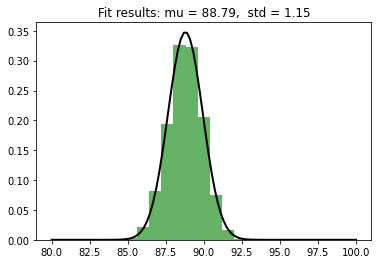

In [ ]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
Ekine_1 = track_df[(track_df.ParticleName == 'proton') & (track_df.CreatorProcess == 0) & (track_df.Ekine > 80)]['Ekine']
mu, std = norm.fit(Ekine_1)
plt.hist(Ekine_1, bins=25, density=True, alpha=0.6, color='g', range=(80, 100))
# Plot the PDF.
x = np.linspace(80, 100, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

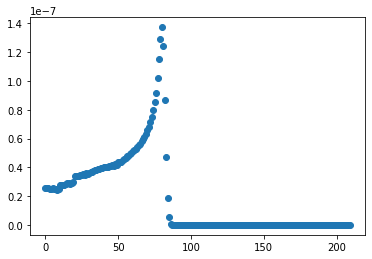

In [ ]:
d = extract_dose('2021May12_164703')
x = np.arange(len(d))
plt.plot(x, d, 'o')

## Export notebooks

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_macrotools.ipynb.
Converted 01_analysis.ipynb.
Converted 02_scanners.ipynb.
Converted 20_analysis0.ipynb.
Converted 21_analysis1.ipynb.
Converted index.ipynb.
